In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [2]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.metrics import mean_squared_error as mse

In [6]:
df = pd.read_csv('inputs/DS1_1440.csv')

In [7]:
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        item = self.x[idx]
        label = self.y[idx]
        
        return item, label

In [36]:
class CNNLSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMForecast, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=1, stride=1)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out


In [37]:
from processing import create_features, split_data

In [38]:
window_size = 5
train_len = int(.6*df.shape[0])

In [39]:
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [40]:
train_data.shape

(864,)

In [41]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [42]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [43]:

input_size = 5 #number of features
hidden_size = 200 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
seq_length = 1

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNLSTMForecast(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [45]:
model

CNNLSTMForecast(
  (cnn): Sequential(
    (0): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [46]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [47]:
NUM_EPOCHS = 200

In [48]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 68.5262680053711
valid_loss 41.36149597167969
epochs 2/200
train_loss 20.04345703125
valid_loss 7.923747539520264
epochs 3/200
train_loss 4.738333702087402
valid_loss 3.0392165184020996
epochs 4/200
train_loss 2.582470655441284
valid_loss 2.2955989837646484
epochs 5/200
train_loss 2.21429181098938
valid_loss 2.1199166774749756
epochs 6/200
train_loss 2.0815882682800293
valid_loss 2.0000979900360107
epochs 7/200
train_loss 1.9646246433258057
valid_loss 1.88474702835083
epochs 8/200
train_loss 1.855276346206665
valid_loss 1.7848113775253296
epochs 9/200
train_loss 1.762558937072754
valid_loss 1.7019723653793335
epochs 10/200
train_loss 1.6861499547958374
valid_loss 1.6333668231964111
epochs 11/200
train_loss 1.6228348016738892
valid_loss 1.5758914947509766
epochs 12/200
train_loss 1.569451093673706
valid_loss 1.5267761945724487
epochs 13/200
train_loss 1.5233675241470337
valid_loss 1.4838536977767944
epochs 14/200
train_loss 1.4827101230621338
valid_loss 1.4456434

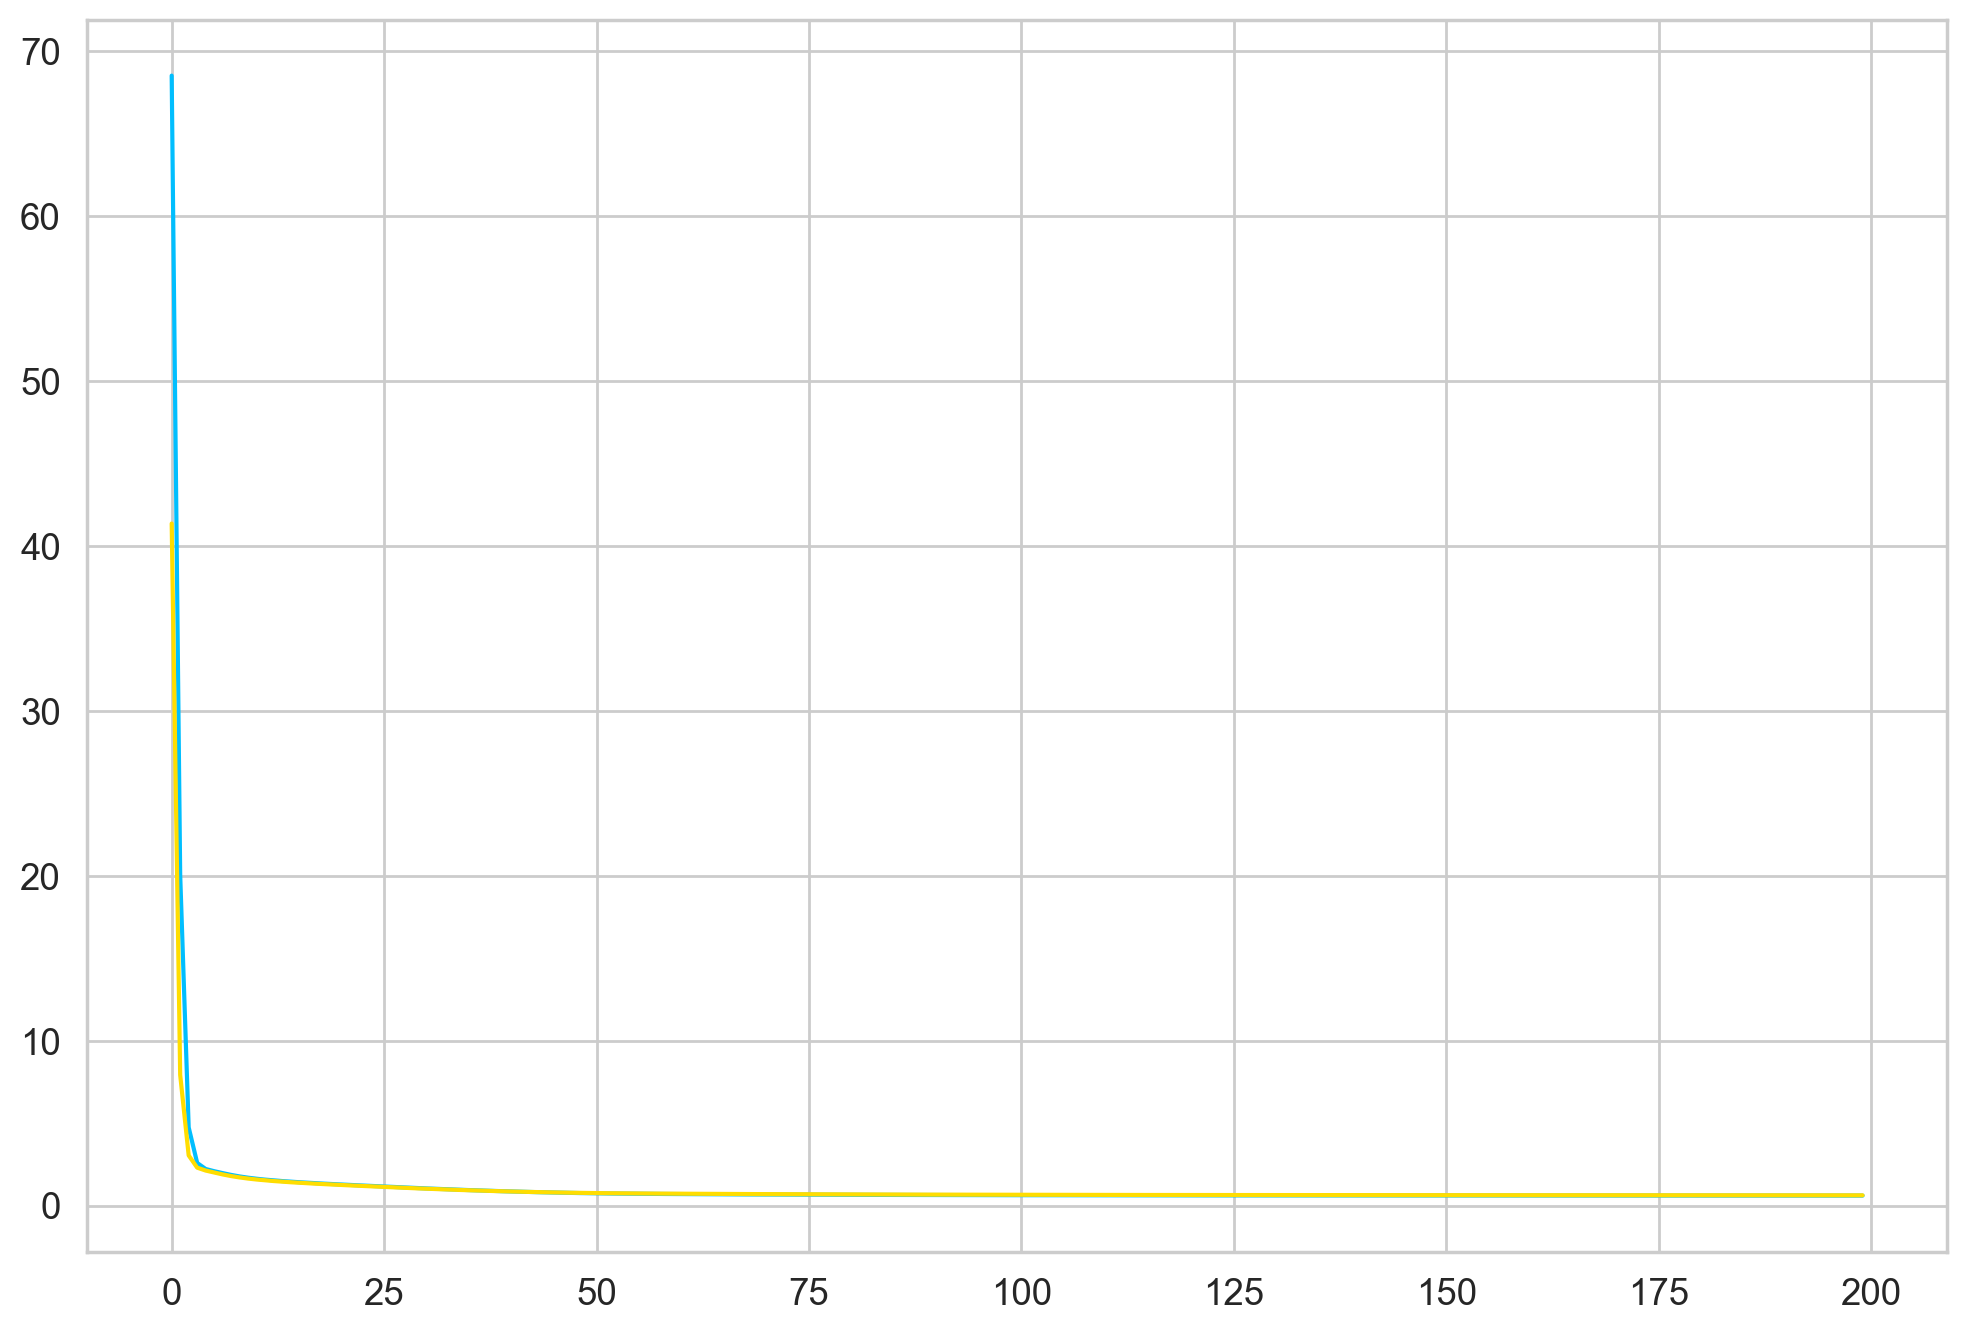

In [49]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [50]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

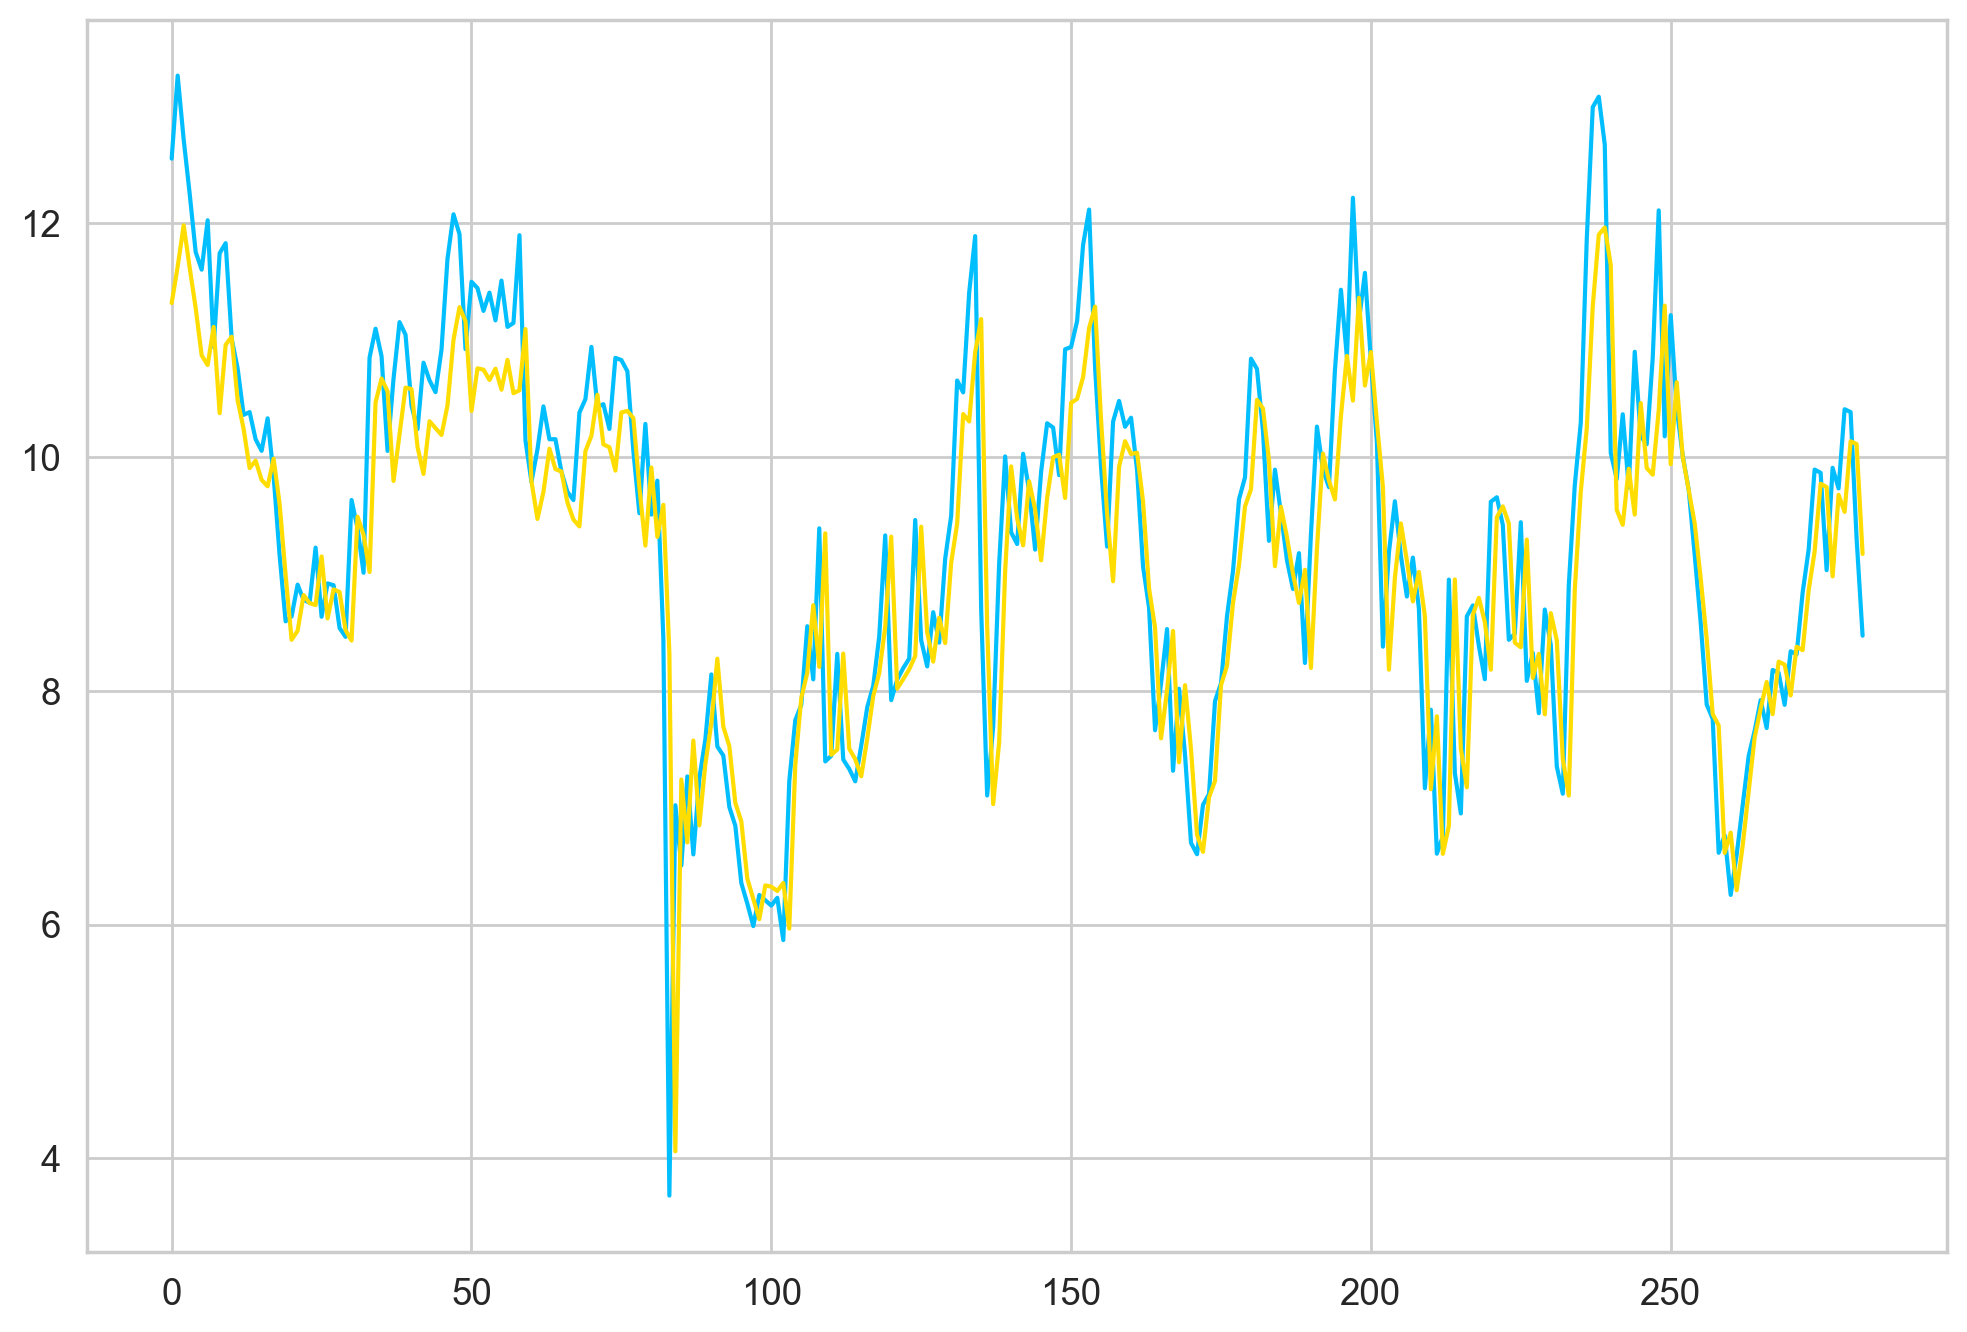

In [51]:
plt.plot(ytest)
plt.plot(predictions)

In [52]:
mse(predictions, ytest)

0.6653048614061066

In [53]:
import pickle

In [54]:
file = open('cnn_lstm_1', 'ab')
pickle.dump(predictions, file)
file.close()

#### May Dataset

In [56]:
df = pd.read_csv('inputs/DS2_1448.csv')

In [57]:
window_size = 5
train_len = int(.6*df.shape[0])

In [58]:
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [59]:
train_data.shape

(892,)

In [60]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [61]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1]), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], 1, xval.shape[1]), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], 1, xtest.shape[1]), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [62]:

input_size = 5 #number of features
hidden_size = 200 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
seq_length = 1

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNLSTMForecast(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [64]:
model

CNNLSTMForecast(
  (cnn): Sequential(
    (0): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [65]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [66]:
NUM_EPOCHS = 200

In [67]:
for epoch in range(NUM_EPOCHS):
    print('epochs {}/{}'.format(epoch+1, NUM_EPOCHS))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 32.79838180541992
valid_loss 21.170379638671875
epochs 2/200
train_loss 9.658403396606445
valid_loss 3.304447650909424
epochs 3/200
train_loss 2.5336437225341797
valid_loss 2.1599464416503906
epochs 4/200
train_loss 2.089764356613159
valid_loss 2.0067105293273926
epochs 5/200
train_loss 1.9509812593460083
valid_loss 1.88918936252594
epochs 6/200
train_loss 1.844057559967041
valid_loss 1.7939714193344116
epochs 7/200
train_loss 1.7597345113754272
valid_loss 1.7196208238601685
epochs 8/200
train_loss 1.69381582736969
valid_loss 1.661148190498352
epochs 9/200
train_loss 1.6412293910980225
valid_loss 1.6141518354415894
epochs 10/200
train_loss 1.598034143447876
valid_loss 1.574711561203003
epochs 11/200
train_loss 1.5613059997558594
valid_loss 1.5412688255310059
epochs 12/200
train_loss 1.5296880006790161
valid_loss 1.5120842456817627
epochs 13/200
train_loss 1.5019006729125977
valid_loss 1.4866187572479248
epochs 14/200
train_loss 1.4773422479629517
valid_loss 1.46

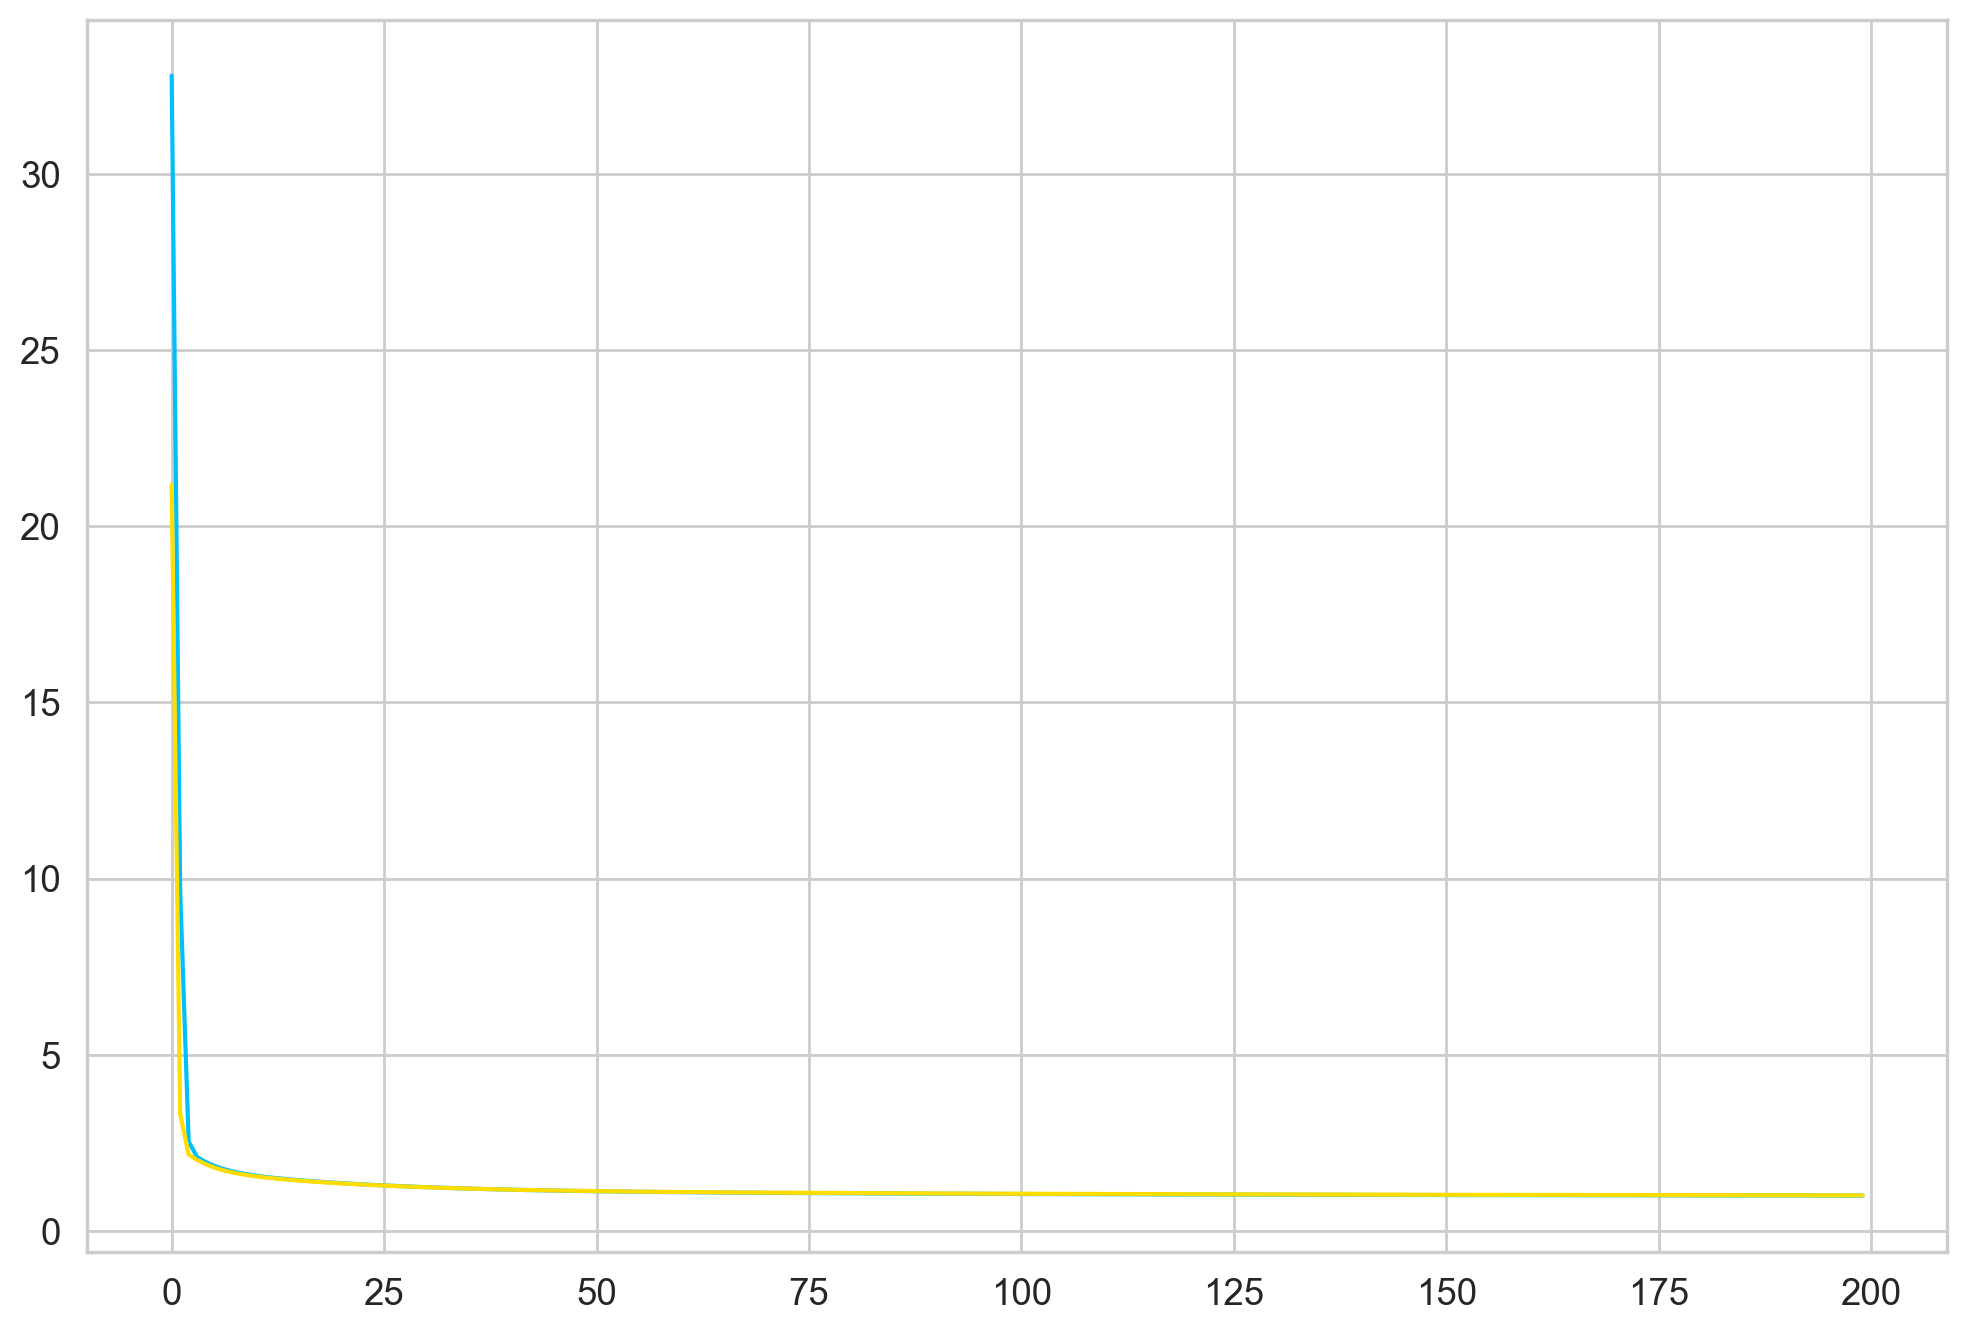

In [68]:
plt.plot(train_losses)
plt.plot(valid_losses)

In [69]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model.forward(inputs)
        predictions.append(preds.item())
        loss = criterion(preds,labels)
        running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

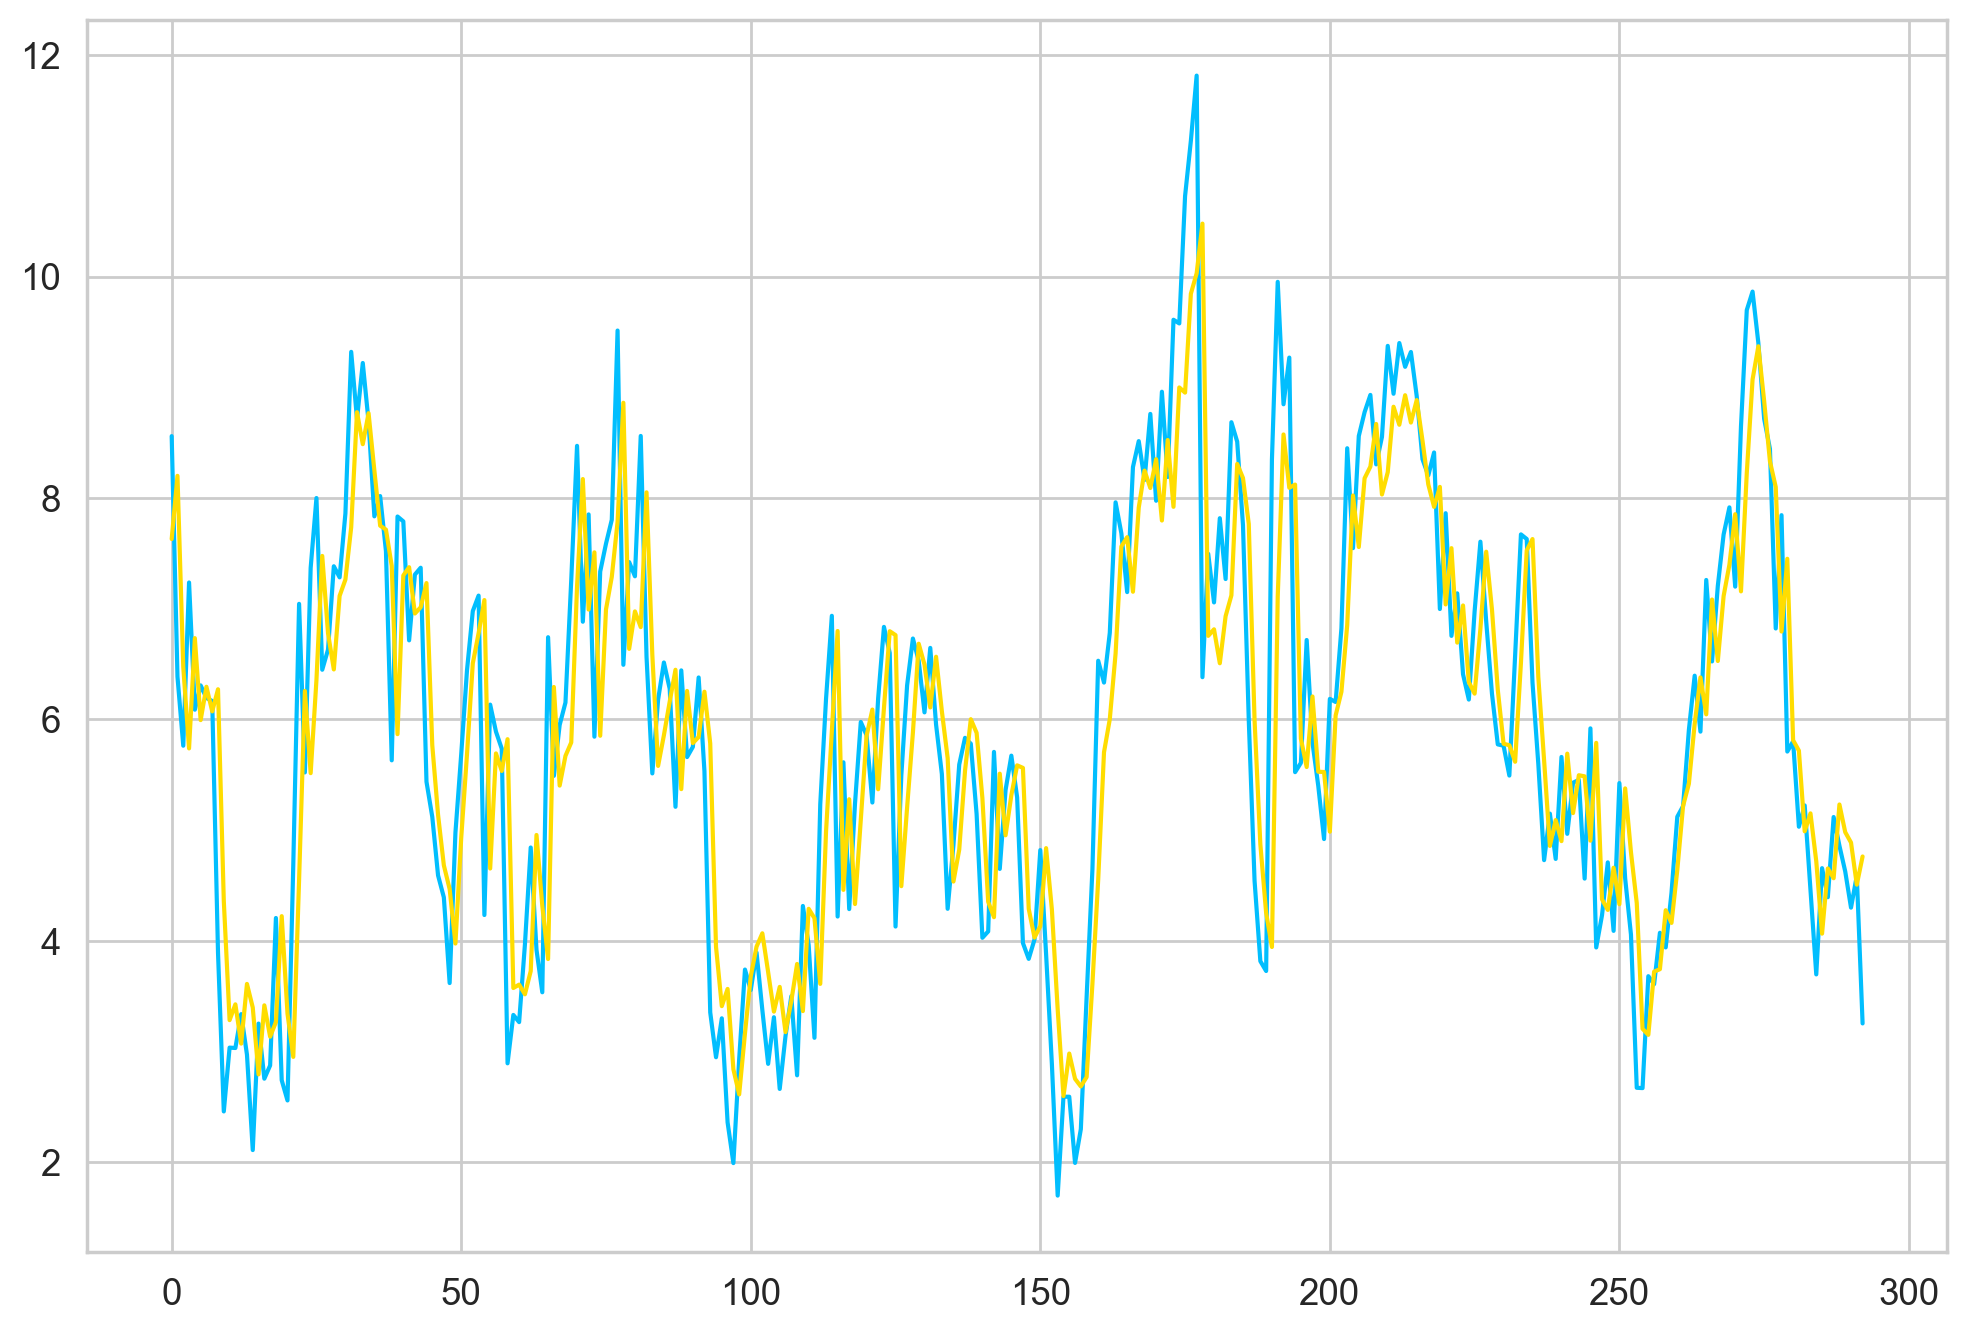

In [70]:
plt.plot(ytest)
plt.plot(predictions)

In [71]:
mse(predictions, ytest)

1.1246515842886908

In [72]:
import pickle

In [73]:
file = open('cnn_lstm_2', 'ab')
pickle.dump(predictions, file)
file.close()